# Positive pixel count and parallel processing with Dask

## Overview
Positive pixel count is a routine that classifies pixels by their position in
[HSI Color Space](https://en.wikipedia.org/wiki/HSL_and_HSV#Hue_and_chroma)
and computes statistics based on this classification.

HistomicsTK has two main functions for positive pixel counting, `count_slide` and `count_image`,
both of which live in the `histomicstk.segmentation.positive_pixel_count` module
(imported in this notebook as simply `ppc`).  `count_image` operates on an in-memory image
in a format compatible with NumPy's `ndarray` type, and returns both the classification statistics
and a label image that may be useful for visualization or further analysis.

`count_slide` accepts a path to an image instead, and while it can also carry out
exactly the same computation as `count_image`, its advantage lies in its ability to distribute
its computation using [Dask](http://dask.pydata.org/en/latest/index.html) and to operate on images
too large to fit in memory.  This ability comes at a cost &ndash; to enable it, the generation of
the label image must be disabled.  (For the curious, the necessary underlying support for writing
large images a tile at a time is lacking.)  The HistomicsTK CLI `PositivePixelCount` is a wrapper
around this function.

The rest of this example is subdivided, in order, into `count_image` and `count_slide` examples, followed by a CLI example.

In [1]:
# Configuration and imports of other libraries
from __future__ import print_function

import large_image
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'

# Import and alias positive_pixel_count
import histomicstk.segmentation.positive_pixel_count as ppc

## Analyzing a small image with `count_image`
We start with `count_image`.  The image we will look at is small and can be analyzed quickly.

Input image


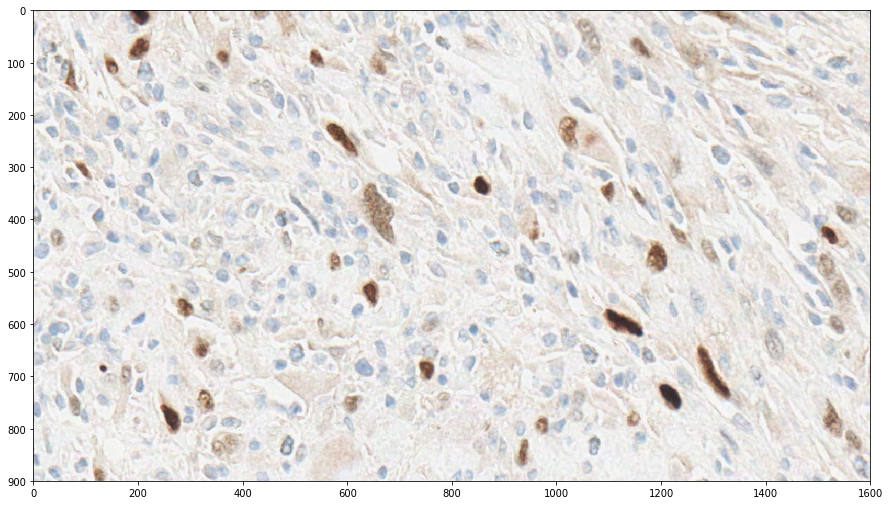

In [3]:
image_url = ('https://data.kitware.com/api/v1/file/'
             '598b71ee8d777f7d33e9c1d4/download')  # DAB.png

im_input = skimage.io.imread(image_url)

print('Input image')
plt.imshow(im_input)
plt.show()

With a helper function, it becomes reasonable to use `count_image` interactively
to explore parameter values.  A more advanced analysis might also look at the HSI values directly.

Here, we show briefly how one can use the helper function `count_and_label` defined below.

In [4]:
def count_and_label(params):
    "Compute the label image with count_image, and then display it"
    label_image = ppc.count_image(im_input, params)[1]
    plt.imshow(label_image)
    plt.show()

To start out, we'll pick a set of parameters.  The HSI color space used by the routines
is defined to use values in the range [0,1].

In [5]:
template_params = ppc.Parameters(
    hue_value=0.05,
    hue_width=0.15,
    saturation_minimum=0.05,
    intensity_upper_limit=0.95,
    intensity_weak_threshold=0.65,
    intensity_strong_threshold=0.35,
    intensity_lower_limit=0.05,
)

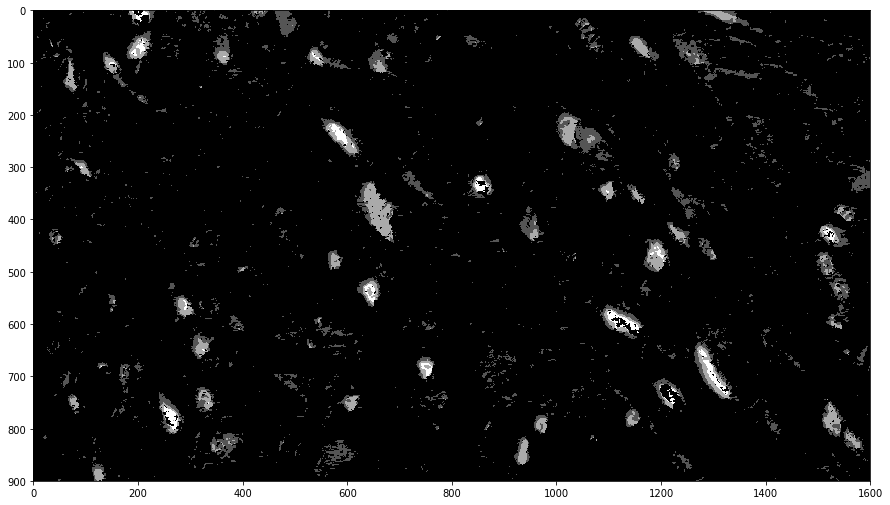

In [6]:
count_and_label(template_params)

Internally, the label values are conveniently increasing, regularly spaced integers.
Black is therefore background / negative, dark gray is weak positive, light gray is positive,
and white is strong positive.  To use the label values programmatically, use of the static
attributes of `ppc.Labels` &ndash; `.NEGATIVE`, `.WEAK`, `.PLAIN`, and `.STRONG` &ndash;
is recommended.

This does a reasonably good job aleady, but let's see what happens if we shift the hue center a bit.
Since `Parameters` is a `collections.namedtuple`, we can use its `._replace` method to substitute a value.

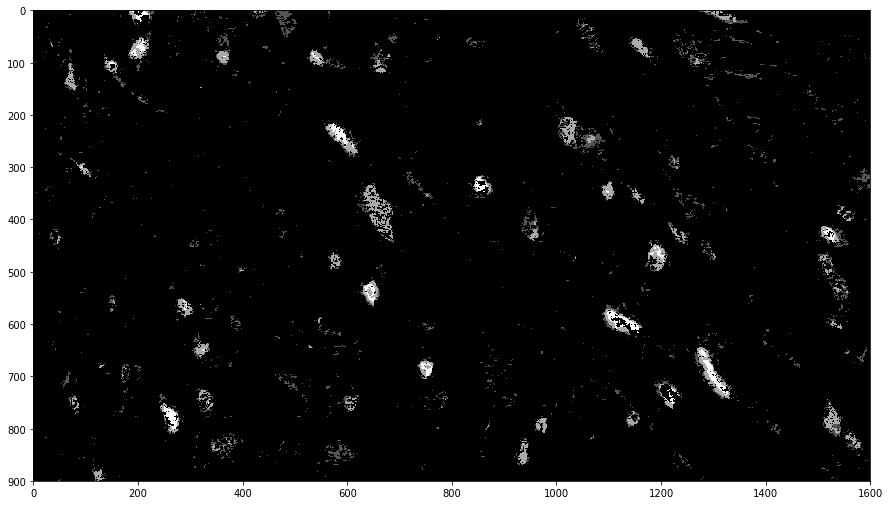

In [7]:
count_and_label(template_params._replace(hue_value=0.))

Here, we see that a number of pixels previously considered positive are now considered negative,
creating holes in visible nuclei.  This indicates that we've moved the hue range too far.

In any case, we can also view the statistics.  Here we use the original parameter values.

In [8]:
stats, label_image = ppc.count_image(im_input, template_params)

def pp_namedtuple(t):
    "Pretty-print a namedtuple by printing each field on its own line and left-aligning all values"
    print(type(t).__name__)
    maxlen = max(map(len, t._fields))
    for f in t._fields:
        print(f, getattr(t, f), sep=':' + ' ' * (maxlen - len(f)) + '\t')

pp_namedtuple(stats)

Output
NumberWeakPositive:             	62163
NumberPositive:                 	24459
NumberStrongPositive:           	4948
IntensitySumWeakPositive:       	49554.6535948
IntensitySumPositive:           	12907.145098
IntensitySumStrongPositive:     	1423.41830065
IntensityAverage:               	0.697665359763
RatioStrongToTotal:             	0.0540351643551
IntensityAverageWeakAndPositive:	0.7210846978


## Analyzing a large image with `count_slide`
`count_slide` has several more parameters than `count_image`.  Besides `make_label_image`,
which controls the creation of the label image as mentioned, there is also `region`, which instructs
`count_slide` to operate on only the specified region of the image.

We will visualize its operation on a small region, and then run it on a larger region.

### Additional setup
First, however, we'll need to download an image and set up Dask.
(The image is 1.630 GiB, so the download takes a while.)

In [9]:
# Comment this out (or just don't run it) once you have the file
!curl -OJ 'https://data.kitware.com/api/v1/file/598b5ee88d777f7d33e9c1d1/download'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1668M  100 1668M    0     0  1237k      0  0:23:01  0:23:01 --:--:-- 1292k
curl: Saved to filename 'TCGA-DX-A6BG-01Z-00-DX2.34763958-0613-4069-9ACC-13D6633FE415.svs'


In [10]:
# Set up a basic configuration.  Change as needed.
import dask.distributed

dask.distributed.Client()

Client Scheduler: tcp://127.0.0.1:43767,Cluster Workers: 8 Cores: 8 Memory: 9.74 GB


### `count_slide` on a small region
Now we can inspect the image.  We'll first run the calculation to produce a label image,
and then run it again without, allowing parallelization.

Using python for large_image caching
The region


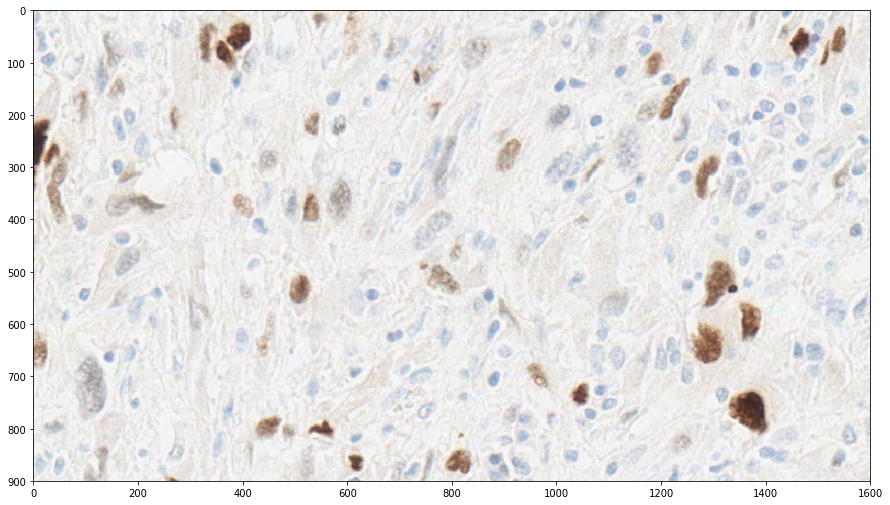

In [11]:
slide_path = 'TCGA-DX-A6BG-01Z-00-DX2.34763958-0613-4069-9ACC-13D6633FE415.svs'
region = dict(
    left=50000, top=35000,
    width=1600, height=900,
)

ts = large_image.getTileSource(slide_path)
im_region = ts.getRegion(region=region, format=large_image.tilesource.TILE_FORMAT_NUMPY)[0]

print("The region")
plt.imshow(im_region)
plt.show()

We'll reuse the parameters from before.

Output
NumberWeakPositive:             	31591
NumberPositive:                 	26850
NumberStrongPositive:           	5582
IntensitySumWeakPositive:       	24633.7385621
IntensitySumPositive:           	13946.745098
IntensitySumStrongPositive:     	1549.14248366
IntensityAverage:               	0.626800152192
RatioStrongToTotal:             	0.087187417022
IntensityAverageWeakAndPositive:	0.660161250836


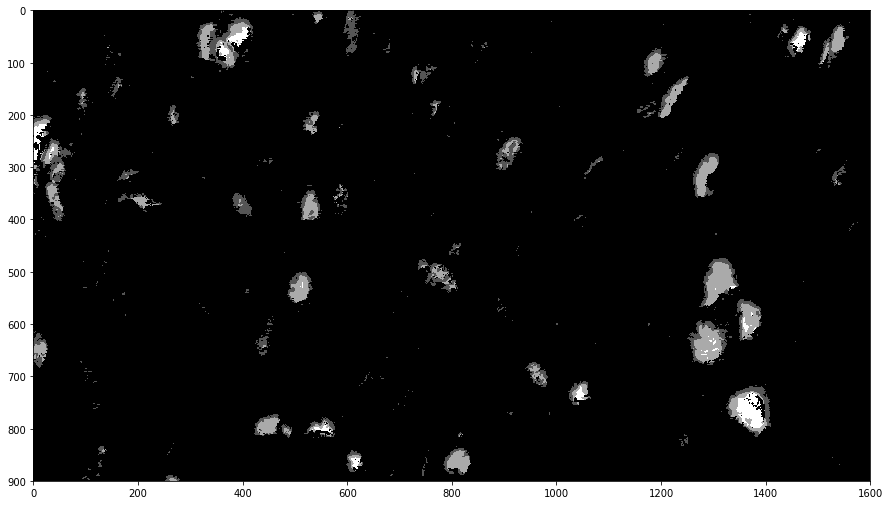

In [12]:
stats, label_image = ppc.count_slide(slide_path, template_params, region=region, make_label_image=True)
pp_namedtuple(stats)
plt.imshow(label_image)
plt.show()

The output is about the same quality as before.  As the small region used
in the previous section is in fact extracted from another part of this slide,
this is not too surprising.

We'll now rerun for only the stats, which will make use of Dask.  `make_label_image`
defaults to `False`, so we simply omit it here.  For the purposes of illustration,
we force `tile_grouping` to 1 to process each tile in its own task.  A larger value, 256,
is used as the default value to reduce the overhead associated with Dask tasks.

In [13]:
# Note that we still return a tuple, though it now has length 1.
stats_dask, = ppc.count_slide(slide_path, template_params, region=region, tile_grouping=1)
pp_namedtuple(stats_dask)

Output
NumberWeakPositive:             	31591
NumberPositive:                 	26850
NumberStrongPositive:           	5582
IntensitySumWeakPositive:       	24633.7385621
IntensitySumPositive:           	13946.745098
IntensitySumStrongPositive:     	1549.14248366
IntensityAverage:               	0.626800152192
RatioStrongToTotal:             	0.087187417022
IntensityAverageWeakAndPositive:	0.660161250836


The results are identical up to a tiny amount of floating point error, as can be seen below:

In [14]:
print("stats_dask - stats:")
pp_namedtuple(ppc.Output(**{f: getattr(stats_dask, f) - getattr(stats, f) for f in ppc.Output._fields}))

stats_dask - stats:
Output
NumberWeakPositive:             	0
NumberPositive:                 	0
NumberStrongPositive:           	0
IntensitySumWeakPositive:       	3.63797880709e-12
IntensitySumPositive:           	0.0
IntensitySumStrongPositive:     	2.27373675443e-13
IntensityAverage:               	1.11022302463e-16
RatioStrongToTotal:             	0.0
IntensityAverageWeakAndPositive:	1.11022302463e-16


### `count_slide` on a large region
As a better exhibition of `count_slide`'s use of parallelism in computing statistics,
we run it here on a much larger region, 30Kx30K pixels.

(By leaving out the `region` parameter, `count_slide` will look at the entire image.
At 146Kx79K pixels, this image will cause `count_slide` to use a lot of memory,
potentially enough to require swap space, without additional configuration of
`large_image`'s caching behavior.)

In [15]:
large_region = dict(
    left=60e3, top=30e3,
    width=30e3, height=30e3,
)

stats, = %time ppc.count_slide(slide_path, template_params, large_region)

pp_namedtuple(stats)

CPU times: user 1.97 s, sys: 854 ms, total: 2.82 s
Wall time: 39.7 s
Output
NumberWeakPositive:             	8017246
NumberPositive:                 	4348294
NumberStrongPositive:           	599706
IntensitySumWeakPositive:       	6295544.71895
IntensitySumPositive:           	2316964.78562
IntensitySumStrongPositive:     	174806.233987
IntensityAverage:               	0.677759275725
RatioStrongToTotal:             	0.0462548878749
IntensityAverageWeakAndPositive:	0.696492794053


## The CLI
Finally, we briefly demonstrate the use of the CLI.  It takes arguments the same as or equivalent to those
of `count_slide`, as well as a `--scheduler` argument that is used to connect to an already running
Dask distributed scheduler if provided.

In [16]:
pp_namedtuple(template_params)
print('\nRegion:', region)

Parameters
hue_value:                 	0.05
hue_width:                 	0.15
saturation_minimum:        	0.05
intensity_upper_limit:     	0.95
intensity_weak_threshold:  	0.65
intensity_strong_threshold:	0.35
intensity_lower_limit:     	0.05

Region: {'width': 1600, 'top': 35000, 'height': 900, 'left': 50000}


In [17]:
%%script sh
# Stats and label image output must be specified via file arguments to
# --returnparameterfile and --outputLabelImage, respectively.
python ../../server/PositivePixelCount/PositivePixelCount.py \
    'TCGA-DX-A6BG-01Z-00-DX2.34763958-0613-4069-9ACC-13D6633FE415.svs' \
    0.05 0.15 0.05 0.95 0.65 0.35 0.05 --region 50000,35000,1600,900 \
    --returnparameterfile stats.txt --outputLabelImage labelImage.png 2>/dev/null

Using python for large_image caching


Here are the results.  Note that, if a label image is output, it's colorized according to colors from
the [coolwarm](https://www.ncl.ucar.edu/Document/Graphics/ColorTables/MPL_coolwarm.shtml) color map.
White is negative, blue is weak positive, gray is positive, and red is strong positive.

stats.txt:
NumberWeakPositive = 31591
NumberPositive = 26850
NumberStrongPositive = 5582
IntensitySumWeakPositive = 24633.7385621
IntensitySumPositive = 13946.745098
IntensitySumStrongPositive = 1549.14248366
IntensityAverage = 0.626800152192
RatioStrongToTotal = 0.087187417022
IntensityAverageWeakAndPositive = 0.660161250836

labelImage.png:


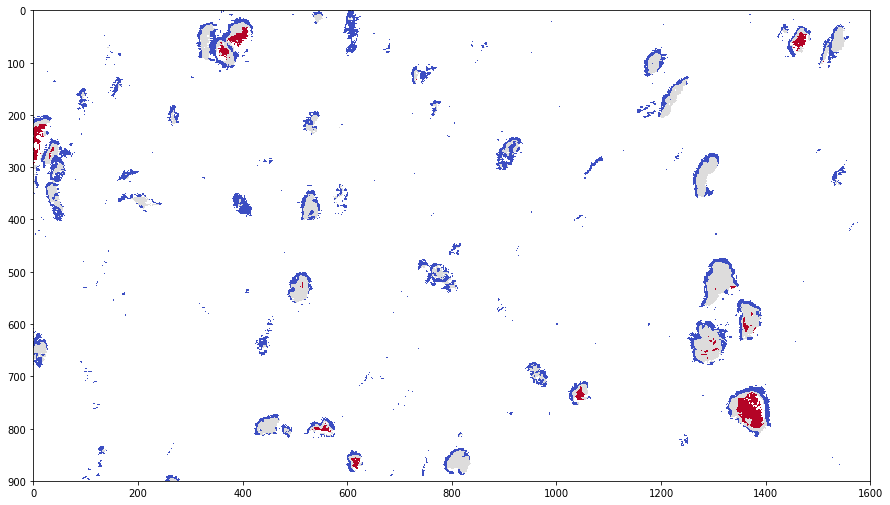

In [18]:
print("stats.txt:")
for l in open('stats.txt'):
    print(l.rstrip())

print("\nlabelImage.png:")
plt.imshow(skimage.io.imread('labelImage.png'))
plt.show()